# Visualizing Price Movement

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [87]:
#path to the data folder, edit if necesssary
path = "./data/"

#filenames
file_power = "competitor_market_prices_power.csv"
file_gas = "competitor_market_prices_gas.csv"
clean_power = "clean_competitor_market_prices_power.csv"
clean_gas = "clean_competitor_market_prices_gas.csv"


#Price Filenames
power_prices = 'power_prices'
gas_prices = 'gas_prices'

In [88]:
#Reading in gas and power prices
df_power_prices = pd.read_csv(path + power_prices, index_col = 'Dates')
df_gas_prices = pd.read_csv(path + gas_prices, index_col = 'date')

df_power_prices = df_power_prices.loc[df_power_prices.index > "2021-05-24"]
df_gas_prices = df_gas_prices.loc[df_gas_prices.index > "2021-05-24"]

df_power_prices

,spot_peak,spot_base,y_ahead_peak,2y_ahead_peak,3y_ahead_peak,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak
Dates,,,,,,,,,,,,,,
2021-05-25,59.137500,59.780417,75.47,72.68,70.68,64.97,61.66,59.90,59.14,59.78,64.77,76.86,71.40,91.49
2021-05-26,66.536667,65.605833,77.00,73.15,71.00,66.21,62.18,60.22,66.54,65.61,66.91,79.14,73.63,93.96
2021-05-27,73.450833,71.767500,75.05,71.82,70.44,64.24,60.53,58.83,73.45,71.77,65.82,76.58,72.16,90.86
2021-05-28,73.577500,73.602083,74.30,71.08,69.50,63.96,60.08,58.13,73.58,73.60,64.96,75.89,70.65,90.33
2021-05-29,45.800833,56.487917,74.05,70.75,69.47,63.52,59.84,57.85,45.80,56.49,53.35,68.40,70.43,90.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10,186.518333,162.090000,581.64,353.67,254.50,427.00,270.00,195.00,186.52,162.09,344.89,389.71,470.80,492.09
2022-10-11,291.780833,259.873750,585.40,355.50,253.50,435.64,270.00,194.92,291.78,259.87,345.31,398.27,469.67,492.92
2022-10-12,299.796667,282.535833,590.00,355.46,253.61,434.00,268.00,193.88,299.80,282.54,341.97,389.53,454.50,485.41


<AxesSubplot:ylabel='Dates'>

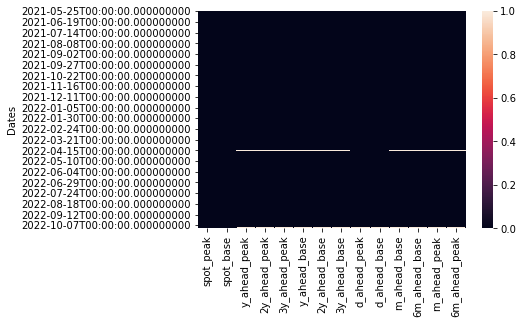

In [110]:
#Visualizing missing price data with heatmap
sns.heatmap(df_power_prices.isnull())

In [124]:
#Dealing with missing price data

df_power_prices.ffill(inplace = True)
df_gas_prices.ffill(inplace = True)

#Sorting gas prices by date ascending
df_gas_prices = df_gas_prices.sort_index()

In [125]:
df_gas_prices.index = pd.to_datetime(df_gas_prices.index)
df_power_prices.index = pd.to_datetime(df_power_prices.index)

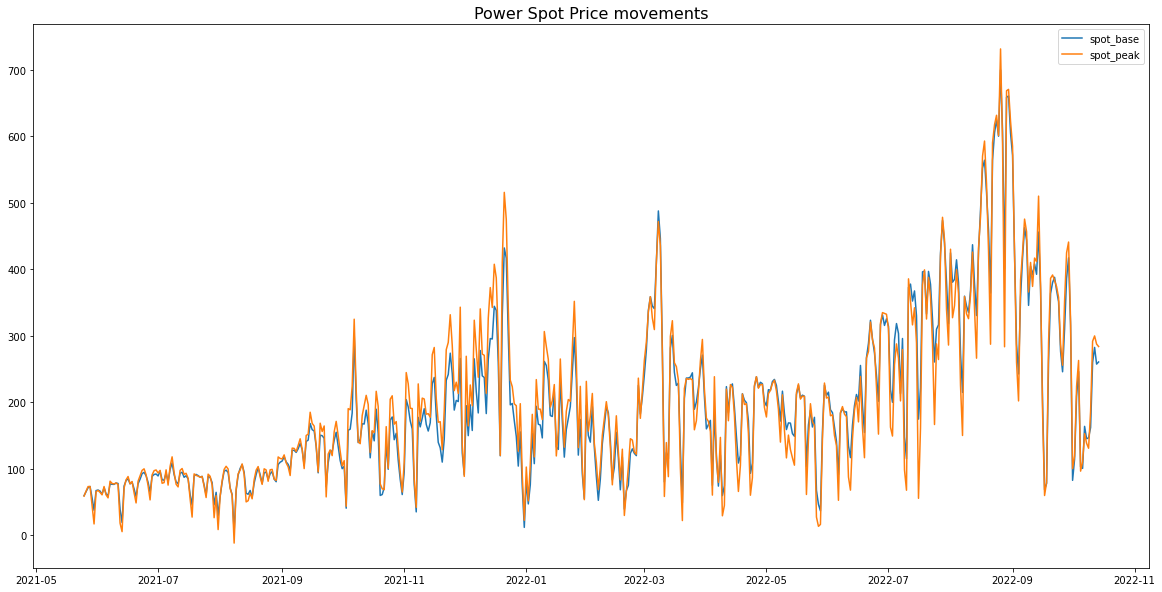

In [126]:
#Visualizing spot price movements
spot_prices = df_power_prices[['spot_peak', 'spot_base']]
y_ahead_prices = df_power_prices[['y_ahead_peak', '2y_ahead_peak', '3y_ahead_peak', 'y_ahead_base', '2y_ahead_base', '3y_ahead_base']]

fig = plt.figure(figsize = (20,10)) 
plt.title("Power Spot Price movements", fontsize='16')
plt.plot(spot_prices.spot_base, label = 'spot_base')
plt.plot(spot_prices.spot_peak, label = 'spot_peak')
plt.legend()
plt.show()

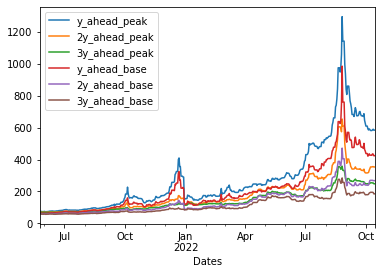

<Figure size 1440x720 with 0 Axes>

In [137]:
#Visualizing future price movements

plot = y_ahead_prices.plot()